In [1]:
import pickle

In [2]:
import os
cwd = os.getcwd()
print(cwd)
os.listdir(cwd)

/Users/sushovanadhikari/Desktop/ISAT_Workspace/dev_env/jupyter_files


['CNN_CurrentFile.ipynb',
 '.DS_Store',
 'data_repository',
 'Untitled.ipynb',
 'CNN_CurrentFile-Copy3.ipynb',
 'CNN_CurrentFile-Copy1.ipynb',
 'CNN_CurrentFile-Copy5.ipynb',
 '.ipynb_checkpoints',
 'CNN_CurrentFile-Copy2.ipynb',
 'CNN_CurrentFile-Copy4.ipynb']

In [3]:
directory = 'data_repository/cifar-10-batches-py/' 

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [5]:
all_data = [0,1,2,3,4,5,6]

In [6]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [7]:
all_data = [0,1,2,3,4,5,6]
for i,direc in zip(all_data, dirs):
    all_data[i] = unpickle(directory+direc)
    

In [8]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [9]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [11]:
x = data_batch1[b"data"]
x = x.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

In [12]:
x[0].max()

255

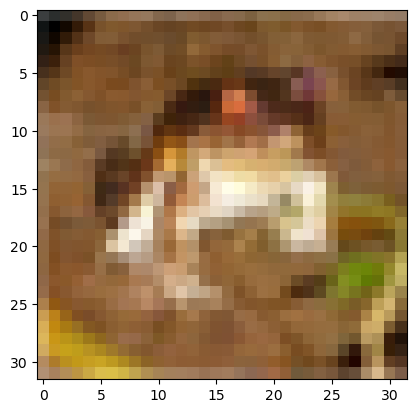

In [13]:
plt.imshow(x[0])

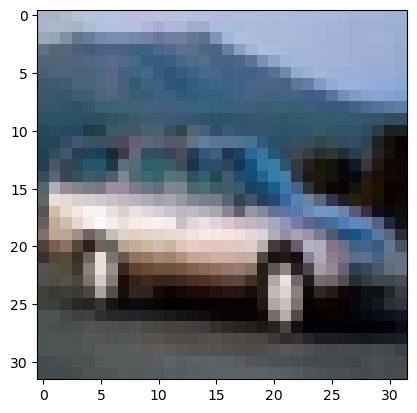

In [14]:
plt.imshow(x[4])

In [15]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10 possible labels
    '''
    n = len(vec)
    
    #np zeros, n rows and vals columns 2D array created here
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1, data_batch2, data_batch3, data_batch4, data_batch5]
        
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_lables = None
        
        self.test_images = None
        self.test_lables = None
        
    def set_up_images(self):
        
        print('Setting up Training Images and Labels')
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]),10)
        
        print('Setting up Test Images and Labels')
        
        self.test_images = np.vstack([d[b'data'] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b'labels'] for d in self.test_batch]),10)
        
        
#here 10,000 images are breaken down in batches,   
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y
 
            

In [16]:
#Before Your tf.Session run these two lines
np.set_printoptions(threshold=np.inf)
ch = CifarHelper()
ch.set_up_images()
#batch = ch.next_batch(100)

Setting up Training Images and Labels
Setting up Test Images and Labels


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2023-03-13 00:25:59.920953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
x = tf.placeholder(tf.float32, shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32, shape=[None,10])
hold_prob = tf.placeholder(tf.float32)

In [19]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


In [20]:
#shape values, 3 diff channel, 32 pixels, 4*4 filter
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [21]:
convo_2 = convolutional_layer(convo_1_pooling, shape = [4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [22]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1,8*8*64])

In [23]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [54]:
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)
# full_one_dropout = tf.nn.dropout(full_layer_one, rate=hold_prob)

In [55]:
y_pred = normal_full_layer(full_one_dropout,10)

In [56]:
y_pred

<tf.Tensor 'add_6:0' shape=(?, 10) dtype=float32>

In [58]:
#  loss function
# create a cross entropy loss function
# true labels, predicted labels
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

In [59]:
#Optimizer
#Create the optimizer using an Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train = optimizer.minimize(cross_entropy)

In [61]:
#Create a variable to initialize all the global tf variables.
init = tf.global_variables_initializer()

In [62]:
#run model using graph session
#perform the training and test prints out in a tf session and run the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(500):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        #print out a message every 100 steps
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            #Test the Train model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            print(sess.run(acc, feed_dict={x:ch.test_images, y_true: ch.test_labels, hold_prob:1.0}))
            print('\n')

2023-03-13 00:47:05.121901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 00:47:05.144376: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Currently on step 0
Accuracy is:
0.1


Currently on step 100
Accuracy is:
0.3894


Currently on step 200
Accuracy is:
0.4503


Currently on step 300
Accuracy is:
0.4794


Currently on step 400
Accuracy is:
0.5018


